In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('fivethirtyeight')

In [54]:
!cat ~/user_state

cat: /root/user_state: No such file or directory


In [55]:
!nvidia-smi

Mon May 27 13:44:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              32W / 250W |    304MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [56]:
def ts_array_create(dirname, dir_list, time_seq):

    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']

    def reamin_HO_time(y_train):
        def f(L):
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())

            out.append(f(a1_out))
        return out

    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):

        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)

        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)

        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)

        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]

    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [57]:
def days_in_file(file, dates):

    for date in dates:
        if date in file: return True
    return False

def train_valid_split(L, valid_size=0.2):

    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))

    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [58]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 10
valid_ratio = 0.2
task = 'classification'

In [59]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to
save_path = "/kaggle/working"

# Define DataSet
dirname = "/kaggle/input/1111111"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']

# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# Select which feature to use.
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]

# xgb DMatrix
train_data1 = xgb.DMatrix(X_train_2d, label=y_train1)
train_data2 = xgb.DMatrix(X_train_fore, label=y_train2_fore)

test_data1 = xgb.DMatrix(X_test_2d, label=y_test1)
test_data2 = xgb.DMatrix(X_test_fore, label=y_test2_fore)

Random seed set as 55688
GPU 0: Tesla P100-PCIE-16GB
Loading training data...


  0%|          | 0/12 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/3 [00:00<?, ?it/s]

In [60]:
y_train1.shape, y_train2.shape


((3144,), (3144,))

In [61]:
# X_train.shape, X_train_2d.shape
# train_dir_list, test_dir_list

### Classification

In [62]:
# Parameters
lr = 0.3
max_d = 7
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
valid_ratio = 0.2

params = {'objective': 'binary:logistic', "tree_method": "hist", 'eta': lr, 'max_depth': max_d,
            'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,
            'seed': seed,'eval_metric': ['error','logloss','aucpr']}

In [63]:
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=train_data1,
    num_boost_round=n_esti,
    evals=[(train_data1, 'train'), (test_data1, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=5,
    # verbose_eval=False
)


[0]	train-error:0.22551	train-logloss:0.56448	train-aucpr:0.84549	valid-error:0.45407	valid-logloss:0.69175	valid-aucpr:0.52405
[1]	train-error:0.18225	train-logloss:0.50679	train-aucpr:0.89070	valid-error:0.42126	valid-logloss:0.69438	valid-aucpr:0.53269
[2]	train-error:0.14345	train-logloss:0.45868	train-aucpr:0.91621	valid-error:0.41864	valid-logloss:0.69262	valid-aucpr:0.54418
[3]	train-error:0.11927	train-logloss:0.42460	train-aucpr:0.92908	valid-error:0.41470	valid-logloss:0.69493	valid-aucpr:0.54899
[4]	train-error:0.10719	train-logloss:0.38574	train-aucpr:0.94537	valid-error:0.40551	valid-logloss:0.69172	valid-aucpr:0.56133
[5]	train-error:0.09160	train-logloss:0.35230	train-aucpr:0.95569	valid-error:0.38714	valid-logloss:0.69358	valid-aucpr:0.56539
[6]	train-error:0.08429	train-logloss:0.33568	train-aucpr:0.96056	valid-error:0.39108	valid-logloss:0.69413	valid-aucpr:0.56942
[7]	train-error:0.07538	train-logloss:0.31294	train-aucpr:0.96820	valid-error:0.37008	valid-logloss:0.68

In [64]:
# # plot evaluation metrics
# epochs = len(evals_result['train']['error'])
# x_axis = range(0, epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['error'], label='Train')
# ax.plot(x_axis, evals_result['valid']['error'], label='valid')
# ax.legend()
# plt.ylabel('Error')
# plt.title('XGBoost Error')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['logloss'], label='Train')
# ax.plot(x_axis, evals_result['valid']['logloss'], label='valid')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['aucpr'], label='Train')
# ax.plot(x_axis, evals_result['valid']['aucpr'], label='valid')
# ax.legend()
# plt.ylabel('aucpr')
# plt.title('XGBoost aucpr')

# plt.show()

In [65]:
preds = model.predict(test_data1)

th: 0.2; Acc: 59.71128608923885; precision: 0.54; recall:0.81; f1:0.65
th: 0.3; Acc: 61.811023622047244; precision: 0.57; recall:0.69; f1:0.62
th: 0.4; Acc: 60.498687664041995; precision: 0.58; recall:0.56; f1:0.57
th: 0.5; Acc: 60.367454068241464; precision: 0.59; recall:0.45; f1:0.51
th: 0.6; Acc: 59.31758530183727; precision: 0.61; recall:0.34; f1:0.44
th: 0.7; Acc: 58.661417322834644; precision: 0.64; recall:0.25; f1:0.36
th: 0.8; Acc: 57.74278215223097; precision: 0.67; recall:0.17; f1:0.27


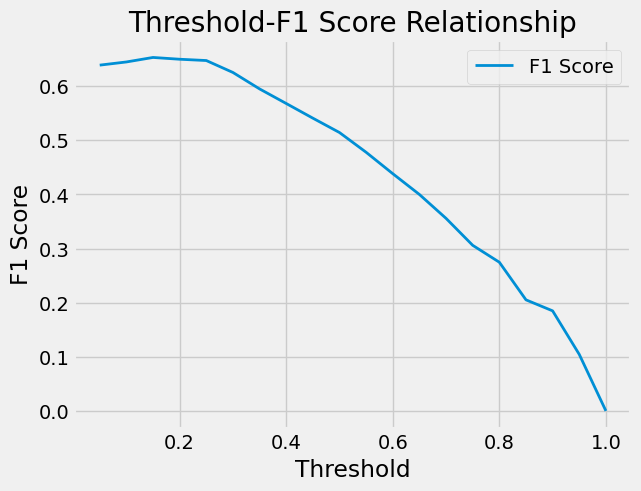

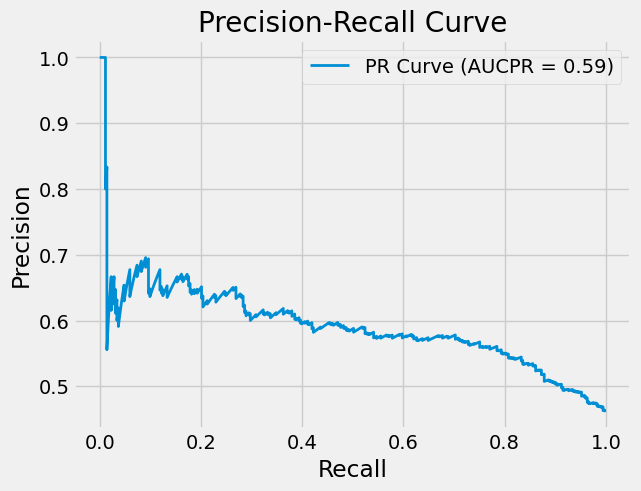

ROC Auc is 0.6530125989596681.


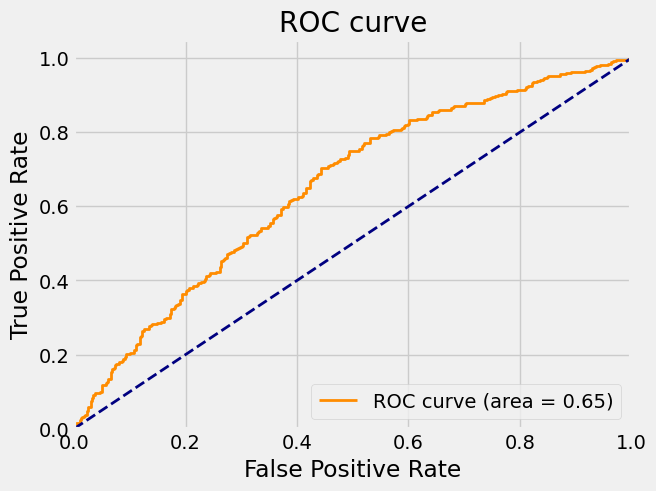

In [82]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast0':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
elif task == 'classification':
# elif task == 'forecast':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)

    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)

    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [84]:
aucpr

0.5912753588581016

In [70]:
split_time_test

[(0, 248), (248, 496), (496, 762)]

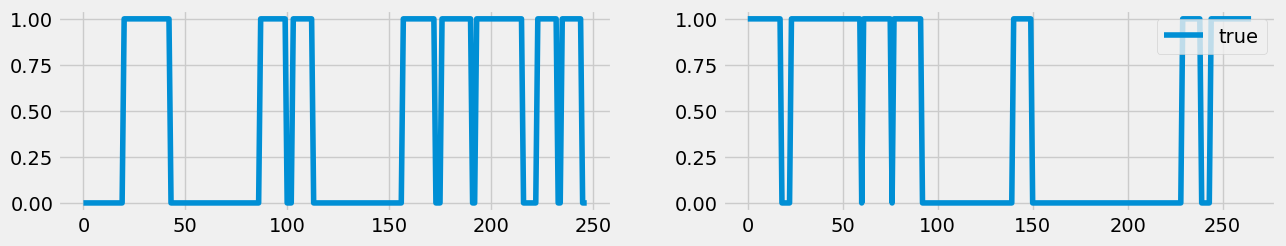

In [71]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[1], split_time_test[2]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediction = [preds[i] for i in range(samples[i][0], samples[i][1])]
    # prediction = [1 if preds[i] > 0.5 else 0  for i in range(samples[i][0], samples[i][1])]
    # axs[i].plot(prediction, label='pred')

plt.legend()
plt.show()

In [72]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-03-26_qc00_02_All.csv', '2023-03-26_qc03_03_All.csv']

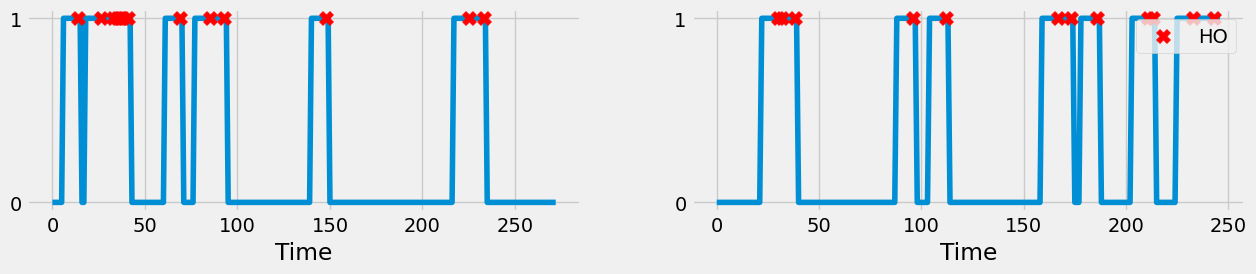

In [73]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(train_data1)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true)
    # Plot Handover happen place
    arr = [y_train2[i] for i in range(samples[i][0], samples[i][1])]
    indices = (np.roll(arr, -1) == 1)
    indices[0] = False
    xy = [(i, 1) for i, x in enumerate(indices) if x == True]
    x = [a[0] for a in xy]
    y = [a[1] for a in xy]
    axs[i].scatter(x, y, marker="X", color='red', s=100, zorder=2, label='HO')

    axs[i].set_yticks([0, 1])
    axs[i].set_xlabel('Time')
    prediction = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    # prediction = [1 if preds_train[i] > 0.5 else 0  for i in range(samples[i][0], samples[i][1])]
    # axs[i].plot(prediction, label='pred')

plt.legend()
plt.show()

### Forecast

In [75]:
# Parameters
lr = 0.3
max_d = 7
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
task = 'forecast'

params = {
        "objective": "reg:squarederror", "tree_method": "hist", 'eta': lr, 'max_depth': max_d,
        'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,
        'seed': seed,'eval_metric': ['rmse', 'mae']
        }

In [77]:
evals_result = {}
# model2 = xgb.train(
#     params=params,
#     dtrain=train_data2,
#     num_boost_round=600,
#     evals=[(train_data2, 'train'), (test_data2, 'valid')],
#     early_stopping_rounds=10,
#     # verbose_eval=False
# )


model2 = xgb.train(
    params=params,
    dtrain=train_data2,
    num_boost_round=n_esti,
    evals=[(train_data2, 'train'), (test_data2, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=5,
    # verbose_eval=False
)

[0]	train-rmse:2.32570	train-mae:1.96742	valid-rmse:2.72424	valid-mae:2.30916
[1]	train-rmse:1.94801	train-mae:1.62265	valid-rmse:2.68392	valid-mae:2.24726
[2]	train-rmse:1.64035	train-mae:1.34493	valid-rmse:2.68155	valid-mae:2.21753
[3]	train-rmse:1.38945	train-mae:1.12287	valid-rmse:2.67609	valid-mae:2.20374
[4]	train-rmse:1.22846	train-mae:0.97394	valid-rmse:2.68068	valid-mae:2.19863
[5]	train-rmse:1.08659	train-mae:0.85142	valid-rmse:2.67718	valid-mae:2.19247
[6]	train-rmse:0.97059	train-mae:0.75040	valid-rmse:2.66803	valid-mae:2.17609
[7]	train-rmse:0.87148	train-mae:0.66682	valid-rmse:2.67625	valid-mae:2.16926
[8]	train-rmse:0.78153	train-mae:0.58977	valid-rmse:2.67602	valid-mae:2.16206
[9]	train-rmse:0.70189	train-mae:0.52466	valid-rmse:2.66939	valid-mae:2.14976
[10]	train-rmse:0.65683	train-mae:0.48404	valid-rmse:2.68014	valid-mae:2.15762
[11]	train-rmse:0.59147	train-mae:0.43312	valid-rmse:2.68746	valid-mae:2.15677
[12]	train-rmse:0.54012	train-mae:0.39659	valid-rmse:2.68791	v

In [80]:
preds2 = model2.predict(test_data2)

th: 0.2; Acc: 59.71128608923885; precision: 0.54; recall:0.81; f1:0.65
th: 0.3; Acc: 61.811023622047244; precision: 0.57; recall:0.69; f1:0.62
th: 0.4; Acc: 60.498687664041995; precision: 0.58; recall:0.56; f1:0.57
th: 0.5; Acc: 60.367454068241464; precision: 0.59; recall:0.45; f1:0.51
th: 0.6; Acc: 59.31758530183727; precision: 0.61; recall:0.34; f1:0.44
th: 0.7; Acc: 58.661417322834644; precision: 0.64; recall:0.25; f1:0.36
th: 0.8; Acc: 57.74278215223097; precision: 0.67; recall:0.17; f1:0.27


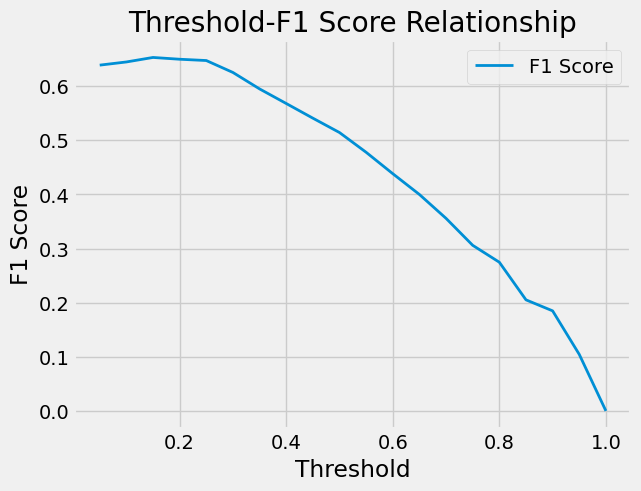

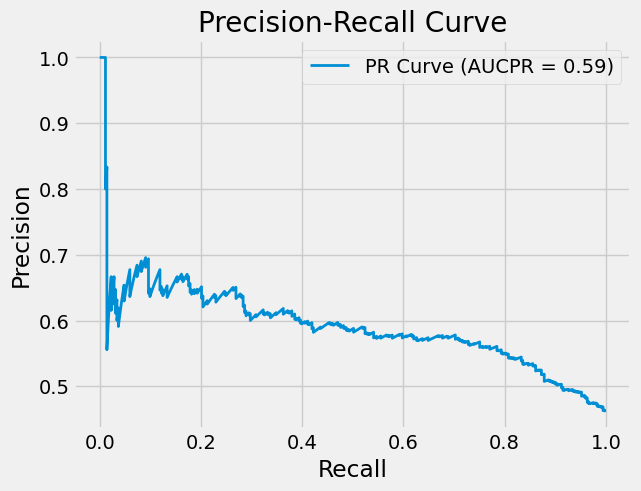

ROC Auc is 0.6530125989596681.


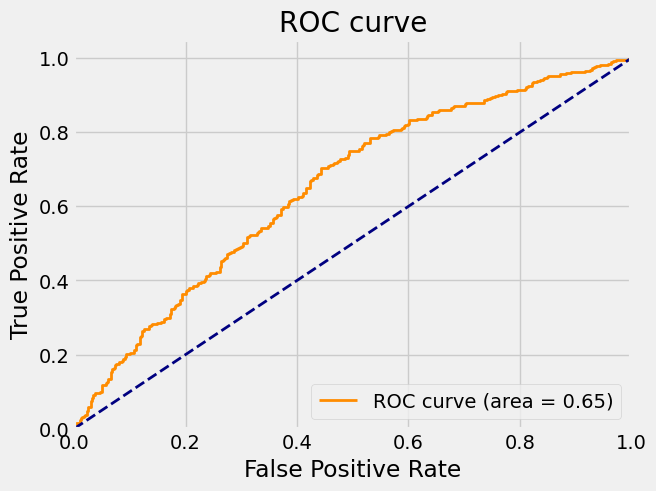

In [85]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast0':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
# elif task == 'classification' or 'forecast':
elif task == 'forecast':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)

    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)

    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [86]:
aucpr

0.5912753588581016

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds2, squared=False)
mae = mean_absolute_error(y_test2_fore, preds2)
rmse, mae

# grid search

## Search on task

In [ ]:
import itertools

In [ ]:
# Load Data
valid_ratio = 0.2
task = 'forecast'

dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# Select which feature to use.
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']

num_of_features = len(features)

# Prediction Task
target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

 # record file
out = '../info/forecast_lte_HO.csv'
f_out = open(out, mode='w')
cols_out = ['t_seq','t_pred','lr','max_dep','n_esti','subsample','colsample_bytree','reg_alpha','gamma','rmse','mae']
f_out.write(','.join(cols_out)+'\n')

time_seqs = [20]
predict_ts = list(range(1,31))

# Parameters
lrs = [0.3]
max_ds = [7]
n_estis = [200]
subsamples = [1]
colsample_bytrees = [0.9]
reg_alphas = [0.5]
gammas = [0.1]

for time_seq, predict_t in itertools.product(time_seqs, predict_ts):

        # Data
        print('Loading training data...')
        X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
        X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
        cond = y_train2 > 0
        X_train_fore = X_train_2d[cond]
        y_train2_fore = y_train2[cond]


        print('Loading testing data...')
        X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
        X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
        cond = y_test2 > 0
        X_test_fore = X_test_2d[cond]
        y_test2_fore = y_test2[cond]

        # xgb DMatrix
        train_data1 = xgb.DMatrix(X_train_2d, label=y_train1)
        train_data2 = xgb.DMatrix(X_train_fore, label=y_train2_fore)

        test_data1 = xgb.DMatrix(X_test_2d, label=y_test1)
        test_data2 = xgb.DMatrix(X_test_fore, label=y_test2_fore)

        for lr, max_d, n_esti, subsample, colsample_bytree, reg_alpha, gamma in itertools.product(lrs, max_ds, n_estis, subsamples, colsample_bytrees, reg_alphas, gammas):

                params = {
                        "objective": "reg:squarederror", "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
                        'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,
                        'seed': seed,'eval_metric': ['rmse', 'mae']
                        }

                model = xgb.train(
                params=params, dtrain=train_data2, num_boost_round=600,
                evals=[(train_data2, 'train'), (test_data2, 'valid')], early_stopping_rounds=10, verbose_eval=False
                )

                preds = model.predict(test_data2)

                rmse = mean_squared_error(y_test2_fore, preds, squared=False)
                mae = mean_absolute_error(y_test2_fore, preds)

                cols_out = [time_seq, predict_t, lr, max_d, n_esti, subsample, colsample_bytree, reg_alpha, gamma, rmse,mae]
                cols_out = [str(n) for n in cols_out]
                f_out.write(','.join(cols_out)+'\n')

        print(f'rmse: {rmse}, mae: {mae}')

f_out.close()

# Classification and Forecast

## Visualization

In [ ]:
test_data = xgb.DMatrix(X_test_2d)
preds_ho = model1.predict(test_data)
preds_ho_time = model2.predict(test_data)

In [ ]:
ans = np.where(preds_ho>0.5, preds_ho_time, 0)

In [ ]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[0], split_time_test[1]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):

    true_ho_time = [y_test2[i] for i in range(samples[i][0], samples[i][1])]

    axs[i].plot(true_ho_time, label='true')
    prediciton_ho = [ans[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton_ho, label='pred')

plt.legend()
plt.show()

In [ ]:
# save model
save_path = '/home/wmnlab/Documents/sheng-ru/model/'
save_name = 'nr_HO_fcst_xgb.json'
f = os.path.join(save_path, save_name)
model2.save_model(f)